In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

def split_data(inputs, label, tokens, split_one = 1400, split_two = 1562, split_three = 1988):
	'''Helper function for splitting data into train, validation and test splits.'''

	def get_splits(X, s1, s2, s3):
		return X[:s1], X[s1 + 20:s2], X[s2:s3]

	input_train, input_val, input_test = get_splits(inputs, split_one, split_two, split_three)
	token_train, token_val, token_test = get_splits(tokens, split_one, split_two, split_three)
	lab_train, lab_val, lab_test = get_splits(label, split_one, split_two, split_three)

	return input_train, input_val, input_test, token_train, token_val, token_test, lab_train, lab_val, lab_test

def accuracy_calc(x,y):
	'''
	This is a function used to calculate accuracy in the price movement experiment.
	If the absolute value of the difference between the output and the labels is < 0.5, 
	then the output is an accurate prediction
	'''
	s,t = x.size()
	total = s*t
	
	diff = torch.abs(x-y)
	one = torch.ones(s,t)
	zero = torch.zeros(s,t)

	accuracy = torch.where(diff<0.5,one,zero)
	acc_total = torch.sum(accuracy)
	
	percent = acc_total/total
	return percent


def loaders(train_data, val_data, test_data,
	batch_train = 56, batch_val = 142, batch_test = 426):
	'''Helper function to create DataLoaders for training.'''

	train_loader = DataLoader(train_data, batch_size=batch_train, shuffle=False)
	val_loader = DataLoader(val_data, batch_size=batch_val,shuffle=False)
	test_loader = DataLoader(test_data, batch_size=batch_test,shuffle=False)

	return train_loader, val_loader, test_loader

class Ml4fDataset(Dataset):
	'''Custom dataset class so that we can load input, future sequence
	and label data simultaneously during training.'''
	def __init__(self, input_data, label_data, token_data):
		
		self.input_data = input_data
		self.token_data = token_data
		self.label_data = label_data
		
	def __len__(self):
		
		return len(self.input_data)
	
	def __getitem__(self, index):
		
		x = self.input_data[index]
		y_tok = self.token_data[index]
		y = self.label_data[index]
		return x,y,y_tok

class DataPreProcess():
	'''
	This class handles all data pre-processing for the model.
	Init args:
	url_input : location of csv of input data.
	url_label : location of csv of label data.
	potent : number of stocks in the portfolio.
	window : length of the context window.
	label : the experiment to run. Determines the form of
			the output labels. "return" gives labels as daily
			returns, "price" gives raw price, hit gives +ve or -ve 
			"movement" of the stock as 0, 1.
	pred_window : length of the prediction window.
	d_model_e : dimension of the input space e.g. 5 for OHLCV data.
	'''
	def __init__(self, url_input, url_label, potent, window = 8,
		label = 'return', pred_window = 3, d_model_e = 5):
	
		self.url_input = url_input
		self.url_label = url_label
		self.window = window
		self.pred_window = pred_window
		self.label = label
		self.d_model_e = d_model_e
		self.potent = potent
	
  
	def loading_input_data(self):
		''' Load input data.'''
	
		port_df = pd.read_csv(self.url_input)
		port = torch.tensor(port_df.to_numpy())
		return port

	def loading_label_data(self):
		''' Load label data. Setting self.label to False removes the return
		labels which are not required for price prediction.'''

		label_df = pd.read_csv(self.url_label)
		label = torch.tensor(label_df.to_numpy())
	 
		if self.label=='return':
		
			return_label = label[self.window:,self.potent:-self.potent].double()
			return_token = label[self.window-1:-self.pred_window,self.potent:-self.potent].double()
			return return_label, return_token
  
		elif self.label=='hit':
	  
			hit_label = label[self.window:,-self.potent:].double()
			hit_token = label[self.window-1:-self.pred_window,-self.potent:].double()
			return hit_label, hit_token
	
		elif self.label=='price':
	  
			price_label = label[self.window:,:self.potent].double()
			price_token = label[self.window-1:-self.pred_window,:self.potent].double()
			return price_label, price_token

	def shift_window(self):
		'''Creates the input sequences and their corresponding future sequences.'''
	
		x = self.loading_input_data()
		original_tens = x[0:self.window]
		L = x.size(0)
		total_window = self.window + self.pred_window - 1
	
		for i in range(1,L-total_window):
			train_input = x[i:i+self.window]
			original_tens = torch.cat((original_tens,train_input),dim=0)

		return original_tens


	def shift_pred(self):

		y, label_token = self.loading_label_data()
		label_tens = y[0:self.pred_window]
		L = y.size(0)

		for i in range(1,(L+1)-self.pred_window):
			train_label = y[i:i+self.pred_window]
			label_tens = torch.cat((label_tens,train_label),dim=0)

		return label_tens, label_token

	def portfolio_stack(self):

		x = self.shift_window()
		y,y_token = self.shift_pred()

		x_prime = x[:,:self.d_model_e].view(-1,self.window,self.d_model_e)

		y_token_prime = y_token[:,0].view(-1,1)
		
		y_prime = y[:,0].contiguous().view(-1,self.pred_window)
		x_tr, x_v, x_te, y_tok_tr, y_tok_v, y_tok_te, y_tr, y_v, y_te = split_data(x_prime,y_prime,y_token_prime)

		for pos in range(1,self.potent):
		
			x_new = x[:,pos*self.d_model_e:(pos+1)*self.d_model_e].view(-1,self.window,self.d_model_e)
   
			y_token_new = y_token[:,pos].view(-1,1)

			y_new = y[:,pos].contiguous().view(-1,self.pred_window)

			x_new_tr, x_new_v, x_new_te, y_new_tok_tr, y_new_tok_v, y_new_tok_te, y_new_tr, y_new_v, y_new_te = split_data(x_new,y_new,y_token_new)

			x_tr = torch.cat((x_tr,x_new_tr), dim=0)
			x_v = torch.cat((x_v,x_new_v), dim=0)
			x_te = torch.cat((x_te,x_new_te), dim=0)
   
			y_tok_tr = torch.cat((y_tok_tr ,y_new_tok_tr), dim=0)
			y_tok_v = torch.cat((y_tok_v,y_new_tok_v), dim=0)
			y_tok_te = torch.cat((y_tok_te,y_new_tok_te), dim=0)
   
			y_tr = torch.cat((y_tr,y_new_tr), dim=0)
			y_v = torch.cat((y_v,y_new_v), dim=0)
			y_te = torch.cat((y_te,y_new_te), dim=0)

		sizes_check = (x_tr.size(), y_tr.size(),y_tok_tr.size())

		train_data = Ml4fDataset(x_tr,y_tr,y_tok_tr)
		val_data = Ml4fDataset(x_v,y_v,y_tok_v)
		test_data = Ml4fDataset(x_te,y_te,y_tok_te)

		return train_data, val_data, test_data, sizes_check

	
class Normalisation():
	'''We normalise each feature of the input data using MinMaxScaling -
	there are 5. But we only want the max and min values for the close prices. 
	This is the 3rd index. Note that we do batch-wise normalisation since we
	believe this helps avoid the negative impact of outlier values
	which may occur from using longer time periods.'''

	def __init__(self, context_window = 8, predict_window = 3, d_model_e = 5, d_model_d = 1):
	
		self.d_model_e = d_model_e
		self.predict_window = predict_window
		self.context_window = context_window
		self.d_model_d = d_model_d

	def normal(self, x): 
		max_cols = []
		min_cols = []
		
		x = torch.log(x)
		x = x.view(-1, self.d_model_e)
		one,two = x.size()
		x_norm = torch.zeros((one,two),dtype=torch.double)
		for i in range(x.size(1)):
			x_col = x[:,i:i+1]
			max = torch.max(x_col,dim=0)[0]
			max_cols.append(max) 
			min = torch.min(x_col,dim=0)[0]
			min_cols.append(min)
			x_col = (x_col-min)/(max-min)
			x_norm[:,i:i+1] = x_col
		x_norm = x_norm.view(-1,self.context_window,self.d_model_e)

		price_max = torch.exp(max_cols[3])
		price_min = torch.exp(min_cols[3])

		self.prev_max = max_cols[3]
		self.prev_min = min_cols[3]

		return x_norm, price_max, price_min

	def normal_future(self, y, min_ = None, max_ = None):
		''' Log transform and min, max scaling of y. '''
		if min_ is None:
			min_ = self.prev_min
		if max_ is None:
			max_ = self.prev_max

		y = torch.log(y)
		y = (y - min_) / (max_ - min_)
		return y
	

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy

class PositionalEncoding(nn.Module):
	'''
	The positional encoding class is used in the encoder and decoder layers.
	It's role is to inject sequence order information into the data since self-attention
	mechanisms are permuatation equivariant. Naturally, this is not required in the static
	transformer since there is no concept of 'order' in a portfolio.'''

	def __init__(self, window, d_model):
		super().__init__()

		self.register_buffer('d_model', torch.tensor(d_model, dtype = torch.float64))

		pe = torch.zeros(window, d_model)
		for pos in range(window):
			for i in range(0, d_model, 2):
			  pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
				
			for i in range(1, d_model, 2):
			  pe[pos, i] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))             
				
		pe = pe.unsqueeze(0)
		self.register_buffer('pe', pe)
	
	def forward(self, x):
		return x * torch.sqrt(self.d_model) + self.pe[:,:x.size(1)]

def create_mask(seq_len):
	'''
	Create a mask to be used in the decoder.
	Returns a mask of shape (1, seq_len, seq_len)
	'''
	no_peak_mask = np.triu(np.ones((seq_len, seq_len)), k = 1).astype('uint8')
	return torch.from_numpy(no_peak_mask)

def get_clones(module, N):
	'''
	This helper function is used to create copies of encoder and decoder layers.
	These copies of encoder/decoder layers are used to construct the
	complete stacked encoder/decoder modules.
	'''
	return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def scaled_dot_product_attention(k, q, v, mask = None):
	'''
	k : (batch, seq_len_k, heads, d_model)
	q : (batch, seq_len_q, heads, d_model)
	v : (batch, seq_len_v, heads, d_model)

	require seq_len_k == seq_len_v
	'''

	b, _, h, d = k.shape

	k = k.transpose(1, 2).contiguous().view(b * h, -1, d)
	q = q.transpose(1, 2).contiguous().view(b * h, -1, d)
	v = v.transpose(1, 2).contiguous().view(b * h, -1, d)
	
	scores = torch.matmul(q, k.transpose(1, 2))
	if mask is not None:
		scores = scores.masked_fill(mask == 0, -1e9)
	scores = F.softmax(scores,dim=2)

	# Scaled dot-product.
	scores = torch.matmul(scores, v).view(b, h, -1, d)
	return scores.transpose(1, 2).contiguous().view(b, -1, h * d)

class MultiHeadAttention(nn.Module):
	'''This is a Mult-Head wide self-attention class.'''
	def __init__(self, heads, d_model, dropout = 0.1):
		super().__init__()
		
		self.h = heads
		self.d_model = d_model

		self.dropout = nn.Dropout(dropout)
		
		self.q_linear = nn.Linear(d_model, heads * d_model,bias=False)
		self.v_linear = nn.Linear(d_model, heads * d_model,bias=False)
		self.k_linear = nn.Linear(d_model, heads * d_model,bias=False)
		  
		self.unifyheads = nn.Linear(heads * d_model, d_model)

	def forward(self, q, k, v, mask = None):

		b = q.shape[0]

		k = self.k_linear(k).view(b, -1, self.h, self.d_model)
		q = self.q_linear(q).view(b, -1, self.h, self.d_model)
		v = self.v_linear(v).view(b, -1, self.h, self.d_model)

		output = scaled_dot_product_attention(k, q, v, mask = mask)
		output = self.unifyheads(output)

		return output

class FeedForward(nn.Module):
	'''This is a pointwise feedforward network.'''
	def __init__(self, d_model, dff, dropout = 0.1):
		super().__init__()
		
		self.ff = nn.Sequential(
			nn.Linear(d_model, dff),
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(dff, d_model))
	
	def forward(self, x):
		x = self.ff(x)
		return x 

class EncoderLayer(nn.Module):
	'''Encoder layer class.'''
	def __init__(self, heads, d_model, dff, dropout = 0.1):
		super().__init__()

		self.norm_1 = nn.LayerNorm(d_model)
		self.norm_2 = nn.LayerNorm(d_model)

		self.attn = MultiHeadAttention(heads, d_model, dropout = dropout)
		self.ff = FeedForward(d_model, dff)

		self.dropout_1 = nn.Dropout(dropout)
		self.dropout_2 = nn.Dropout(dropout)
	
	def forward(self, x):
		attn_out = self.dropout_1(self.attn(x, x, x))
		x = self.norm_1(x + attn_out)

		ffn_out = self.ff(x)
		x = self.norm_2(x + ffn_out)

		return x

class Encoder(nn.Module):
	'''Stacked encoder layers.'''
	def __init__(self, N, pe_window, heads, inp_dim, d_model, dff, dropout):
		super().__init__()

		self.N = N
		self.embedding = nn.Linear(inp_dim, d_model)
		self.pe = PositionalEncoding(pe_window, d_model)
		self.dynamiclayers = get_clones(EncoderLayer(heads, d_model, dff, dropout = dropout), N)

	def forward(self, x):
		# x (batch, seq_len, inp_dim)

		x = self.embedding(x) # (batch, seq_len, d_model)
		
		x = self.pe(x) # (batch, seq_len, d_model)

		for i in range(self.N):
		  x = self.dynamiclayers[i](x) # (batch, seq_len, d_model)

		return x # (batch, seq_len, d_model)

class DecoderLayer(nn.Module):
	'''Decoder Layer class'''
	def __init__(self, heads, d_model, dff, dropout = 0.1):
		super().__init__()

		self.norm_1 = nn.LayerNorm(d_model)
		self.norm_2 = nn.LayerNorm(d_model)
		self.norm_3 = nn.LayerNorm(d_model)

		self.attn_1 = MultiHeadAttention(heads, d_model, dropout = dropout)
		self.attn_2 = MultiHeadAttention(heads, d_model, dropout = dropout)
		self.ff = FeedForward(d_model, dff)

		self.dropout_1 = nn.Dropout(dropout)
		self.dropout_2 = nn.Dropout(dropout)
		self.dropout_3 = nn.Dropout(dropout)

	def forward(self, x, enc_out, mask = None):
		# x (batch, seq_len, d_model)
		# enc_out (batch, enc_seq_len, d_model)

		attn_1_out = self.dropout_1(self.attn_1(x, x, x, mask = mask))
		x = self.norm_1(x + attn_1_out) # (batch, seq_len, d_model)

		attn_2_out = self.dropout_2(self.attn_2(x, enc_out, enc_out))
		x = self.norm_2(x + attn_2_out) # (batch, seq_len, d_model)

		ffn_out = self.dropout_3(self.ff(x))
		x = self.norm_3(x + ffn_out) # (batch, seq_len, d_model)

		return x # (batch, seq_len, d_model)

class Decoder(nn.Module):
	'''Stacked decoder layers.'''
	def __init__(self, N, pe_window, heads, inp_dim, d_model, dff, dropout = 0.1):
		super().__init__()

		self.N = N
		self.embedding = nn.Linear(inp_dim, d_model)
		self.pe = PositionalEncoding(pe_window, d_model)
		self.decoderlayers = get_clones(DecoderLayer(heads, d_model, dff, dropout = dropout), N)

	def forward(self, x, enc_out, mask = None):
		# x (batch, seq_len, inp_dim)
		# enc_out (batch, enc_seq_len, d_model)

		x = self.embedding(x) # (batch, seq_len, d_model)

		x = self.pe(x) # (batch, seq_len, d_model)
		
		for i in range(self.N):
			x = self.decoderlayers[i](x, enc_out, mask = mask) # (batch, seq_len, d_model)
		
		return x # (batch, seq_len, d_model)

class Ml4fTransformer(nn.Module):
	'''
	Main transformer class.
	experiment : selects sigmoid final activation if 'movement' else linear
	inp_dim_e : number of dimensions of encoder input
	inp_dim_d : number of dimensions of decoder input
	d_model : model embedding dimension
	dff : hidden dimension of feed forward network
	N_e : number of encoder layers
	N_d : number of decoder layers
	heads : number of heads
	'''
	def __init__(self, inp_dim_e, inp_dim_d, experiment = 'return', d_model = 20,
		dff = 80, N_e = 1, N_d = 1, heads = 4, dropout = 0.1, pe_window = 100):
		super().__init__()

		assert d_model % heads == 0
		
		self.encoder = Encoder(N_e, pe_window, heads, inp_dim_e, d_model, dff, dropout = dropout)
		
		self.decoder = Decoder(N_d, pe_window, heads, inp_dim_d, d_model, dff, dropout = dropout)
		
		if experiment == 'hit':
			self.map = nn.Sequential(
				nn.Linear(d_model, 1),
				nn.Sigmoid())
		else:
			self.map = nn.Linear(d_model, 1)
	
	def forward(self, x, y, mask = None):
		'''
		x (batch, in_seq_len, inp_dim_e)
		y (batch, tar_seq_len, inp_dim_d)
		'''

		enc_out = self.encoder(x) # (batch, in_seq_len, d_model)

		dec_out = self.decoder(y, enc_out, mask = mask) # (batch, tar_seq_len, d_model)

		final = self.map(dec_out) # (batch, tar_seq_len, 1)

		return final

class LrSchedule:
	'''
	Implements the learning rate schedule from "Attention is all you need".
	Learning rate given by (1/sqrt(d_model)) * min(steps^-0.5, steps * warmup_steps ^-1.5).

	Init with a pytorch.optim optimizer then call as usual in the training loop.
	'''
	def __init__(self, optimizer, warmup_steps, d_model, scale = 1.0):
		self.optimizer_ = optimizer 
		self.warmup_steps = warmup_steps
		self.d_model = d_model
		self.scale = scale
		self.step_ = 1

	def zero_grad(self):
		self.optimizer_.zero_grad()

	def get_lr(self, step):
		min_ = np.minimum(step ** -0.5, step * (self.warmup_steps ** -1.5))
		return (self.d_model ** -0.5) * min_

	def update_lr(self):
		lr = self.scale * self.get_lr(self.step_)
		self.step_ += 1

		for param_group in self.optimizer_.param_groups:
			param_group['lr'] = lr

	def step(self):
		self.update_lr()
		self.optimizer_.step()

	def reset_lr(self, lr = 1e-3):
		for param_group in self.optimizer_.param_groups:
			param_group['lr'] = lr
	
'''
Inference loop for returns


model.eval()
current_val_loss = 0.0
epoch_prediction = []
	
for data in val_loader_target:
	  with torch.no_grad():

		# Load the data for the current batch.
		# We only require the input and label data, not the future sequence, since we are no longer using teacher forcing like we did during training.
		portfolio,prices,token = data
		# Normalise the input data.
		packet_port,_,_ = data_switch.normal(portfolio)
		token = token.unsqueeze(-2)
		# Compute encoded representation which has dimension [batch_val,context,d_embed]
		encoder_output = model.encoder(packet_port)
	  
		# Create list containing the output at each position.
		feature_seq_list = [token]

		for time_step in range(prediction_window):

			# Pass the stacked list of previous decoder outputs and use this as input to the decoder. We reshape to make sure
			# it has dimension [batch_val,position in sequence,1]
			decoder_input = torch.stack(feature_seq_list,1).view(batch_val,-1,1)
			next_position = model.map(model.decoder(decoder_input,encoder_output,mask=None))
			end_position = next_position[:,time_step:time_step+1,:]
			# Since we already have the previous positions stored in feature_seq_list, we only add the newly computed position. 
			feature_seq_list.append(end_position)

		# next_position will dimension [batch_val,prediction_window,1] so we remove the final dimension.
		predictions = next_position.squeeze(-1)
	  
		# Store each batch of predictions.
		epoch_prediction.append(predictions)

		# Compute per-sequence loss.
		loss = criterion(predictions,prices)
		batch_loss = loss.item()/batch_val
		current_val_loss += batch_loss

	average_val_loss = current_val_loss/(len(val_loader_target))
	loss_val_results.append(average_val_loss)

	# Append epoch predictions if loss performance is better than all previous epochs.
	if epoch > 0 and loss_val_results[-1] == min(loss_val_results):
		predict_epoch = torch.stack(epoch_prediction,0).view(-1,prediction_window)
		best_predictions.append(predict_epoch)

	model.train()

	print('The average loss on the training set for epoch {} is {}.'.format(epoch,average_loss))
	print('The average loss on the validation set for epoch {} is {}'.format(epoch,average_val_loss))
'''


if __name__ == '__main__':

	model = Ml4fTransformer(5, 1)

	x = torch.randn(4, 15, 5)
	y = torch.randn(4, 5, 1)
	mask = create_mask(y.shape[1])

	out = model(x, y, mask)

	print(out)
	print(out.shape)

tensor([[[-0.5307],
         [-0.7975],
         [-0.3393],
         [-0.5799],
         [-0.7211]],

        [[-1.2054],
         [-1.1669],
         [-0.9440],
         [-1.0487],
         [-0.7734]],

        [[-0.5209],
         [-0.3395],
         [-0.7420],
         [-0.5352],
         [-0.4609]],

        [[-0.6944],
         [-0.7660],
         [-0.6819],
         [-0.7351],
         [-0.8054]]], grad_fn=<ViewBackward0>)
torch.Size([4, 5, 1])


In [13]:
import matplotlib.pyplot as plt
y = y.reshape(-1).detach()


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [11]:
out = out.reshape(-1).detach().numpy()

In [12]:
out

array([-0.5307452 , -0.7974974 , -0.33934528, -0.5799381 , -0.7210833 ,
       -1.2054133 , -1.166889  , -0.9439533 , -1.0486615 , -0.7734301 ,
       -0.5209064 , -0.33946407, -0.7420343 , -0.5351704 , -0.46086454,
       -0.6944474 , -0.7659986 , -0.68186736, -0.7351409 , -0.80538267],
      dtype=float32)

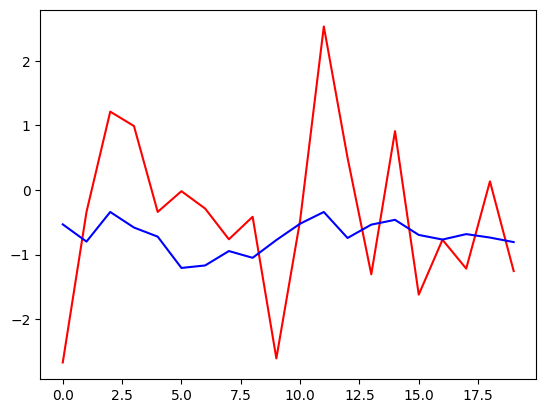

In [14]:
plt.plot(y, color='red')
plt.plot(out, color='blue')

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

input_window = 20
output_window = 10
batch_size = 10 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    time        = np.arange(0, 400, 0.1) # 4000 sample
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    
    sampels = 2800
    train_data = amplitude[:sampels] # 2800
    test_data = amplitude[sampels:] # 1200

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    
    
    return total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

train_data, val_data = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 10 == 0):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number) 
#out = model(src)
#
#print(out)
#print(out.shape)

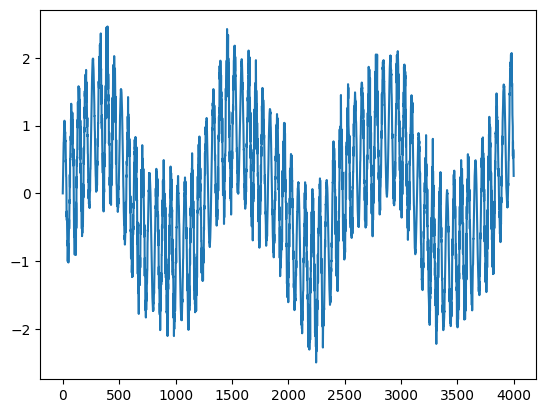

In [20]:
time        = np.arange(0, 400, 0.1)
amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
plt.plot(amplitude)

In [ ]:
for batch, i in enumerate(range(0, 2794, 10)):
    print(batch, i)

In [22]:
train_data, val_data = get_data()

In [25]:
train_data.shape, val_data.shape

(torch.Size([2770, 2, 20]), torch.Size([1170, 2, 20]))

In [42]:
data = train_data[0:0+batch_size]    
data.shape

torch.Size([10, 2, 20])

In [31]:
input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))

In [50]:
input.shape, target.shape

(torch.Size([20, 10, 1]), torch.Size([20, 10, 1]))

In [49]:
tmp = torch.stack([item[0] for item in data]).chunk(input_window,1) # chunk, dim=1


In [47]:
for item in data:
    print(item[0].shape)

torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
